In [1]:
import dataLoader as loader
import HDDMmodelMaker as ddm
import pandas as pd
import time
import matplotlib.pyplot as plt
import hddm
import random
import scipy.stats as st
import numpy as np
import seaborn as sns
import pymc as mc
import random 
import kabuki
from mpl_toolkits.mplot3d import Axes3D
import statsmodels

/Users/eladiomontero/opt/anaconda3/envs/decTimesEnv/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
data = hddm.load_csv('./raw data/output_data.dat')
session = data["player"].str.split("_", n=1, expand=True)
data["session"] = session[0]
data["treatment"] = ""
data.loc[data["session"].isin(['s1m5', 's2m5', 's4m8', 's8n3', 's9n3', 's10n5']), 'treatment'] = "fix"
data.loc[data["session"].isin(['s5m20', 's6m22', 's7m22', 's11n9', 's12n11', 's13n12']), 'treatment'] = "changing"
data.loc[data["session"].isin(['s3m7']), 'treatment'] = "weak"
data.head()

,round,player,action_player,opponent,action_opponent,payoff,time_php,time_js,who_played,session,treatment
0,1,s3m7_usuario9,D,['s3m7_usuario18'],C,4,4480.199814,4452,user,s3m7,weak
1,1,s3m7_usuario18,C,['s3m7_usuario9'],D,0,9472.300053,9443,user,s3m7,weak
2,1,s3m7_usuario7,C,['s3m7_usuario10'],C,3,2238.199949,2213,user,s3m7,weak
3,1,s3m7_usuario10,C,['s3m7_usuario7'],C,3,8133.699894,8101,user,s3m7,weak
4,1,s3m7_usuario13,C,['s3m7_usuario5'],C,3,5098.500013,5043,user,s3m7,weak


In [198]:
#Import data_actions.csv from now on, time intensive
data["actions"] = ""
nrounds = data["round"].unique()
players = data.player.unique()
for r in nrounds:
    for p in players:
        action1 = ""
        if r == 1: action1 = "00"
        else:
            action1 = "%s%s" % (data.loc[(data["round"] == r-1) & (data["player"] == p), "action_player"].item(),
                                data.loc[(data["round"] == r-1) & (data["player"] == p), "action_opponent"].item())
        data.loc[(data["round"] == r) & (data["player"] == p), ['actions']] = "%s%s" % (action1, data.loc[(data["round"] == r) & (data["player"] == p), "action_player"].item())
data.to_csv("data_actions.csv")

In [199]:
#Some more format, ignore and import data_actions.csv from now on
data = hddm.load_csv("data_actions.csv")

del data["who_played"], data["time_php"]
data.rename(columns={'time_js': 'rt'}, inplace=True)
data['rt'] = data.rt.astype(int)
data["response"] = data["action_player"]
data.loc[data['response'] == "C", "response"] = 1.0
data.loc[data['response'] == "D", "response"] = 0.0
data["rt"] = data["rt"] / 1000
data = hddm.utils.flip_errors(data)
data["abs_time"] = data["rt"].abs()
del data["Unnamed: 0"]


data.to_csv("data_actions.csv")

In [3]:
# START FROM HERE 
data = hddm.load_csv("data_actions.csv")


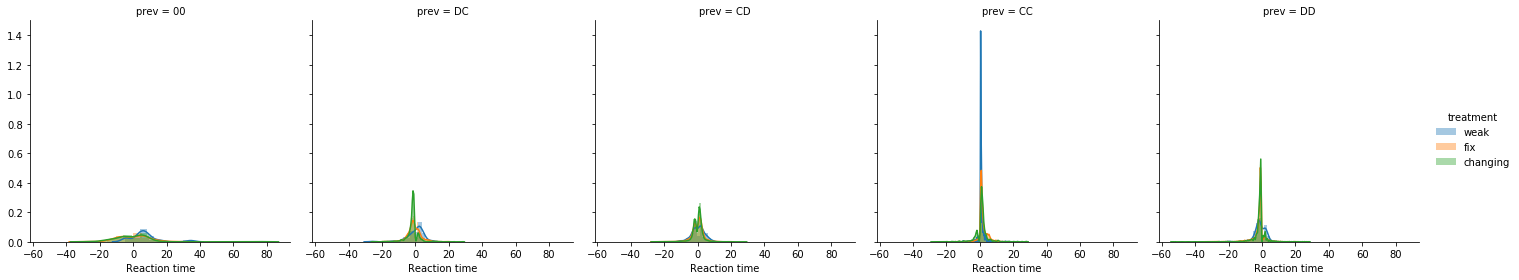

In [4]:
data["prev"] = data.actions.str[:2]
g = sns.FacetGrid(data, col="prev", hue = "treatment", height = 4)
g.map(sns.distplot, "rt")
g.add_legend()
g.set(xlabel = "Reaction time")

In [5]:
def actionChange(actions1, actions2, user1, user2, rt):
    if len(actions1) != len(actions2): return "Lenghts mismatch" #Raise exception
    rounds = len(actions1)
    prev1 = ""
    prev2 = ""
    switch_events = pd.DataFrame(columns=["type", "lag", "subject", "round", "rt"])
    lag = 0
    for r in range(0, rounds):
        if r ==0:
            prev1 = actions1[r]
            prev2 = actions2[r]
            lag += 1
            continue
        elif actions1[r] != prev1:
            switch_events = switch_events.append(
                {"context": prev2, "type": "%s%s" % (prev1, actions1[r]),
                 "lag": lag, "subject": user1, "round": r + 1, "rt": rt[r]}, ignore_index=True)
            lag = 0
        if actions2[r] == prev2:
            lag += 1
        else: lag = 1
        prev1 = actions1[r]
        prev2 = actions2[r]
    return switch_events

In [6]:
def actionCounts(actions, user):
    prosocial = ['CCC', 'CDC', '00C', 'DDC', 'DCC']
    proself = ['DDD', 'DCD', '00D', 'CCD', 'CDD']
    rating = 0
    act_df = {'user':user,'00D':0,'00C':0,'DCD':0,'CDC':0,'CCC':0,'CDD':0,'CCD':0,'DDC':0,'DCC':0,'DDD':0, 'type':""}
    for a in actions:
        act_df[a] = act_df[a] + 1
        if a in prosocial:
            rating = rating + 1
        else: rating = rating - 1
    if rating >= 0: act_df["type"] = "Pro-social"
    else: act_df["type"] = "Pro-self"
    return act_df

In [7]:
switches = pd.DataFrame()
actions = pd.DataFrame()
for t in data.treatment.unique():
    t_df = data.loc[(data.treatment == t)]
    users = t_df.player.unique()
    switchesT = pd.DataFrame()
    actionsT = pd.DataFrame()
    for u in users:
        df = t_df.loc[t_df.player == u]
        df = df.sort_values(by = "round", ascending = True)
        opp = str(df.opponent.unique())
        acc1 = df.action_player.values
        acc2 = df.action_opponent.values
        rt = df["rt"].values
        switchesT = switchesT.append(actionChange(acc1, acc2, u, opp, rt))
        actionsT = actionsT.append(actionCounts(df.actions, u), ignore_index=True)
    switchesT["treatment"] = t
    actionsT["treatment"] = t
    switches = switches.append(switchesT, ignore_index = True)
    actions = actions.append(actionsT, ignore_index = True)

/Users/eladiomontero/opt/anaconda3/envs/decTimesEnv/lib/python2.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [8]:
switches

,context,lag,round,rt,subject,type,treatment
0,C,1,2,5.401,s3m7_usuario9,DC,weak
1,C,1,3,-10.751,s3m7_usuario9,CD,weak
2,C,1,4,3.443,s3m7_usuario9,DC,weak
3,C,2,6,-5.265,s3m7_usuario9,CD,weak
4,C,1,7,5.641,s3m7_usuario9,DC,weak
5,D,1,8,-10.555,s3m7_usuario9,CD,weak
6,C,1,9,10.590,s3m7_usuario9,DC,weak
7,C,1,10,-7.549,s3m7_usuario9,CD,weak
8,D,1,11,2.952,s3m7_usuario9,DC,weak
9,C,1,14,-1.764,s3m7_usuario9,CD,weak


In [9]:
actions.loc[actions.treatment == "fix"]

,00C,00D,CCC,CCD,CDC,CDD,DCC,DCD,DDC,DDD,type,user,treatment
18,0.0,1.0,95.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,Pro-social,s4m8_usuario2,fix
19,1.0,0.0,95.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,Pro-social,s4m8_usuario7,fix
20,1.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pro-social,s4m8_usuario14,fix
21,1.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pro-social,s4m8_usuario13,fix
22,0.0,1.0,96.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,Pro-social,s4m8_usuario9,fix
23,1.0,0.0,96.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,Pro-social,s4m8_usuario10,fix
24,1.0,0.0,40.0,13.0,20.0,2.0,8.0,5.0,7.0,4.0,Pro-social,s4m8_usuario8,fix
25,1.0,0.0,53.0,0.0,1.0,12.0,11.0,11.0,1.0,10.0,Pro-social,s4m8_usuario1,fix
26,0.0,1.0,56.0,5.0,9.0,3.0,3.0,5.0,6.0,12.0,Pro-social,s4m8_usuario11,fix
27,0.0,1.0,60.0,1.0,2.0,6.0,6.0,6.0,2.0,16.0,Pro-social,s4m8_usuario4,fix


In [10]:
data_svo = pd.merge(data, actions[["type", "user"]], left_on = "player", right_on = "user")
data_svo

,Unnamed: 0,round,player,action_player,opponent,action_opponent,payoff,rt,session,treatment,actions,response,abs_time,prev,type,user
0,0,1,s3m7_usuario9,D,['s3m7_usuario18'],C,4,-4.452,s3m7,weak,00D,0,4.452,00,Pro-social,s3m7_usuario9
1,18,2,s3m7_usuario9,C,['s3m7_usuario18'],C,3,5.401,s3m7,weak,DCC,1,5.401,DC,Pro-social,s3m7_usuario9
2,36,3,s3m7_usuario9,D,['s3m7_usuario18'],C,4,-10.751,s3m7,weak,CCD,0,10.751,CC,Pro-social,s3m7_usuario9
3,54,4,s3m7_usuario9,C,['s3m7_usuario18'],C,3,3.443,s3m7,weak,DCC,1,3.443,DC,Pro-social,s3m7_usuario9
4,72,5,s3m7_usuario9,C,['s3m7_usuario18'],C,3,6.401,s3m7,weak,CCC,1,6.401,CC,Pro-social,s3m7_usuario9
5,90,6,s3m7_usuario9,D,['s3m7_usuario18'],C,4,-5.265,s3m7,weak,CCD,0,5.265,CC,Pro-social,s3m7_usuario9
6,108,7,s3m7_usuario9,C,['s3m7_usuario18'],D,0,5.641,s3m7,weak,DCC,1,5.641,DC,Pro-social,s3m7_usuario9
7,126,8,s3m7_usuario9,D,['s3m7_usuario18'],C,4,-10.555,s3m7,weak,CDD,0,10.555,CD,Pro-social,s3m7_usuario9
8,144,9,s3m7_usuario9,C,['s3m7_usuario18'],C,3,10.590,s3m7,weak,DCC,1,10.590,DC,Pro-social,s3m7_usuario9
9,162,10,s3m7_usuario9,D,['s3m7_usuario18'],D,0,-7.549,s3m7,weak,CCD,0,7.549,CC,Pro-social,s3m7_usuario9


In [11]:
display(data_svo.head())
display(actions.head())

,Unnamed: 0,round,player,action_player,opponent,action_opponent,payoff,rt,session,treatment,actions,response,abs_time,prev,type,user
0,0,1,s3m7_usuario9,D,['s3m7_usuario18'],C,4,-4.452,s3m7,weak,00D,0,4.452,00,Pro-social,s3m7_usuario9
1,18,2,s3m7_usuario9,C,['s3m7_usuario18'],C,3,5.401,s3m7,weak,DCC,1,5.401,DC,Pro-social,s3m7_usuario9
2,36,3,s3m7_usuario9,D,['s3m7_usuario18'],C,4,-10.751,s3m7,weak,CCD,0,10.751,CC,Pro-social,s3m7_usuario9
3,54,4,s3m7_usuario9,C,['s3m7_usuario18'],C,3,3.443,s3m7,weak,DCC,1,3.443,DC,Pro-social,s3m7_usuario9
4,72,5,s3m7_usuario9,C,['s3m7_usuario18'],C,3,6.401,s3m7,weak,CCC,1,6.401,CC,Pro-social,s3m7_usuario9


,00C,00D,CCC,CCD,CDC,CDD,DCC,DCD,DDC,DDD,type,user,treatment
0,0.0,1.0,69.0,9.0,1.0,2.0,9.0,1.0,3.0,5.0,Pro-social,s3m7_usuario9,weak
1,1.0,0.0,74.0,4.0,9.0,1.0,2.0,1.0,3.0,5.0,Pro-social,s3m7_usuario18,weak
2,1.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pro-social,s3m7_usuario7,weak
3,1.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pro-social,s3m7_usuario10,weak
4,1.0,0.0,97.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,Pro-social,s3m7_usuario13,weak


In [12]:
actions.loc[actions.treatment == "weak", "type"].value_counts()

Pro-social    18
Name: type, dtype: int64

In [13]:
data.payoff.unique()

array([4, 0, 3, 1])

In [14]:
## Checking how many rows are there per context
fix = data_svo[data_svo.treatment == "fix"]
for a in fix.prev.unique():
    for t in fix["type"].unique():
        df = fix.loc[(fix.prev == a) & (fix["type"] == t)]
        print("%s %s %d" % (a, t, len(df.index)))

00 Pro-social 34
00 Pro-self 24
DC Pro-social 235
DC Pro-self 376
CD Pro-social 399
CD Pro-self 212
DD Pro-social 269
DD Pro-self 1555
CC Pro-social 2463
CC Pro-self 233


In [15]:
## Checking how many rows are there per context
fix = data_svo[data_svo.treatment == "fix"]
fix

,Unnamed: 0,round,player,action_player,opponent,action_opponent,payoff,rt,session,treatment,actions,response,abs_time,prev,type,user
1800,1800,1,s4m8_usuario2,D,['s4m8_usuario7'],C,4,-4.600,s4m8,fix,00D,0,4.600,00,Pro-social,s4m8_usuario2
1801,1814,2,s4m8_usuario2,D,['s4m8_usuario7'],C,4,-6.756,s4m8,fix,DCD,0,6.756,DC,Pro-social,s4m8_usuario2
1802,1828,3,s4m8_usuario2,C,['s4m8_usuario7'],D,0,8.987,s4m8,fix,DCC,1,8.987,DC,Pro-social,s4m8_usuario2
1803,1842,4,s4m8_usuario2,D,['s4m8_usuario7'],D,1,-5.750,s4m8,fix,CDD,0,5.750,CD,Pro-social,s4m8_usuario2
1804,1856,5,s4m8_usuario2,C,['s4m8_usuario7'],C,3,10.820,s4m8,fix,DDC,1,10.820,DD,Pro-social,s4m8_usuario2
1805,1870,6,s4m8_usuario2,C,['s4m8_usuario7'],C,3,6.138,s4m8,fix,CCC,1,6.138,CC,Pro-social,s4m8_usuario2
1806,1884,7,s4m8_usuario2,C,['s4m8_usuario7'],C,3,3.556,s4m8,fix,CCC,1,3.556,CC,Pro-social,s4m8_usuario2
1807,1898,8,s4m8_usuario2,C,['s4m8_usuario7'],C,3,1.599,s4m8,fix,CCC,1,1.599,CC,Pro-social,s4m8_usuario2
1808,1912,9,s4m8_usuario2,C,['s4m8_usuario7'],C,3,1.419,s4m8,fix,CCC,1,1.419,CC,Pro-social,s4m8_usuario2
1809,1926,10,s4m8_usuario2,C,['s4m8_usuario7'],C,3,1.636,s4m8,fix,CCC,1,1.636,CC,Pro-social,s4m8_usuario2


In [86]:
actions_list = ['DCD', 'DCC', 'CDD', 'DDC', 'CCC', 'CDC', 'DDD',
       'CCD']
modeler = ddm.HDDMmodelMaker()
st = time.time()
contextDf = pd.DataFrame()
window = 10
for a in actions_list:
    df = fix.loc[fix["actions"]==a]
    try:
        model = modeler.fit_model(df, 5000, 200)
        print("\nModel: %s, time: %f\n" % (a, time.time() - st))
        modStats = modeler.get_stats(model, subjects = True)
        modStats["actions"] = a
        contextDf = contextDf.append(modStats, ignore_index = True)
    except: break
    contextDf.to_csv("./outputs/%s_svo.csv" % (a))

 [-----------------100%-----------------] 5000 of 5000 complete in 24.7 sec
Model: DCD, time: 25.025319

 [-----------------100%-----------------] 5000 of 5000 complete in 32.7 sec
Model: DCC, time: 58.254206

 [-----------------100%-----------------] 5000 of 5000 complete in 22.5 sec
Model: CDD, time: 81.290827

 [-----------------100%-----------------] 5000 of 5000 complete in 22.7 sec
Model: DDC, time: 104.502801

 [-----------------100%-----------------] 5000 of 5000 complete in 65.7 sec
Model: CCC, time: 170.643716

 [-----------------100%-----------------] 5000 of 5000 complete in 24.4 sec
Model: CDC, time: 195.538278

 [-----------------100%-----------------] 5000 of 5000 complete in 45.7 sec
Model: DDD, time: 241.832812

 [-----------------100%-----------------] 5000 of 5000 complete in 21.9 sec
Model: CCD, time: 264.213755



In [87]:
contextDf

,mean,std,2.5q,25q,50q,75q,97.5q,mc err,param,subject,actions
0,2.78149,0.636902,1.30431,2.40825,2.92142,3.2103,3.83394,0.0148882,a,None,DCD
1,0.943849,0.690711,0.152392,0.425312,0.769667,1.27452,2.70579,0.021255,a_std,None,DCD
2,3.42658,0.110023,3.20281,3.35521,3.42676,3.50191,3.64033,0.00325328,a,Pro-self,DCD
3,2.99187,0.119386,2.76221,2.91169,2.98856,3.07041,3.23659,0.00442004,a,Pro-social,DCD
4,0.273134,0.97273,-1.52644,-0.233118,0.18584,0.674335,2.57073,0.0156791,v,None,DCD
5,1.29754,0.872921,0.301945,0.643331,1.05701,1.7083,3.53281,0.0231695,v_std,None,DCD
6,-0.342891,0.0525969,-0.44556,-0.378507,-0.342825,-0.308125,-0.237774,0.00128307,v,Pro-self,DCD
7,0.477546,0.0638167,0.351713,0.434664,0.47804,0.519138,0.603346,0.00215351,v,Pro-social,DCD
8,0.353415,0.164179,0.103181,0.231416,0.330648,0.453376,0.734344,0.00546435,t,None,DCD
9,0.744459,0.478925,0.066654,0.378861,0.670574,1.02537,1.87034,0.0210491,t_std,None,DCD


In [88]:
actions_list = ['DCD', 'DCC', 'CDD', 'DDC', 'CCC', 'CDC', 'DDD',
       'CCD']
modeler = ddm.HDDMmodelMaker()
st = time.time()
contextDfMin = pd.DataFrame()
for a in actions_list:
    df = fix.loc[fix["actions"]==a]
    df = df.sample(n = 76, random_state = 1)
    try:
        model = modeler.fit_model(df, 5000, 200)
        print("\nModel: %s, time: %f\n" % (a, time.time() - st))
        modStats = modeler.get_stats(model, subjects = True)
        modStats["actions"] = a
        contextDfMin = contextDfMin.append(modStats, ignore_index = True)
    except: break
    #contextDf.to_csv("./outputs/%s_svo.csv" % (a))

 [-----------------100%-----------------] 5000 of 5000 complete in 21.7 sec
Model: DCD, time: 22.104858

 [-----------------100%-----------------] 5000 of 5000 complete in 23.4 sec
Model: DCC, time: 46.017219

 [-----------------100%-----------------] 5000 of 5000 complete in 19.9 sec
Model: CDD, time: 66.373445

 [-----------------100%-----------------] 5000 of 5000 complete in 28.0 sec
Model: DDC, time: 94.826553

 [-----------------100%-----------------] 5000 of 5000 complete in 22.3 sec
Model: CCC, time: 117.581413

 [-----------------100%-----------------] 5000 of 5000 complete in 19.0 sec
Model: CDC, time: 137.009129

 [-----------------100%-----------------] 5000 of 5000 complete in 19.2 sec
Model: DDD, time: 156.663102

 [-----------------100%-----------------] 5000 of 5000 complete in 19.2 sec
Model: CCD, time: 176.402502



In [92]:
contextDfMin.loc[contextDfMin.subject== "Pro-self", ["mean", "param", "actions"]]

,mean,param,actions
2,3.1689,a,DCD
6,-0.32257,v,DCD
10,0.0422914,t,DCD
14,0.521914,z,DCD
18,3.24892,a,DCC
22,-0.257053,v,DCC
26,0.0124248,t,DCC
30,0.474402,z,DCC
34,3.40943,a,CDD
38,-0.474713,v,CDD


In [402]:
df1 = fix.loc[(fix["prev"]=="CC")]
df2 = fix.loc[(fix["prev"]=="CD")]

display(df1.response.value_counts())
display(df2.response.value_counts())

1    2542
0     154
Name: response, dtype: int64

1    348
0    263
Name: response, dtype: int64

In [403]:
model = modeler.fit_model(df, 5000, 200)
model2 = modeler.fit_model(df2, 5000, 200)

 [-----------------100%-----------------] 5000 of 5000 complete in 14.0 sec

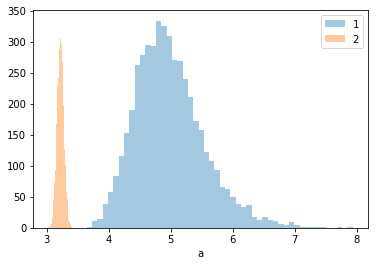

In [409]:
sns.distplot(model.get_traces()["a"], kde=False, label = "1")
sns.distplot(model2.get_traces()["a"], kde=False, label = "2")
plt.legend()

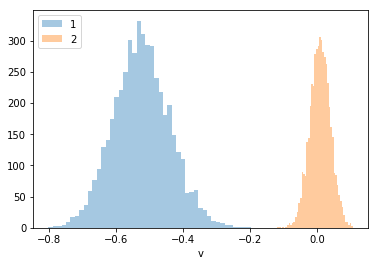

In [410]:
sns.distplot(model.get_traces()["v"], kde=False, label = "1")
sns.distplot(model2.get_traces()["v"], kde=False, label = "2")

plt.legend()

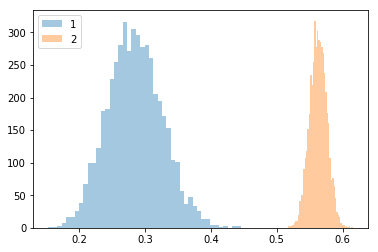

In [411]:
z_trans = model.get_traces()["z_trans"]
z_trans2 = model2.get_traces()["z_trans"]
sns.distplot(mc.invlogit(z_trans), kde=False, label = "1")
sns.distplot(mc.invlogit(z_trans2), kde=False, label = "2")
plt.legend()

In [407]:
model.gen_stats()

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,4.98214,0.558383,4.06425,4.58708,4.9166,5.29717,6.27087,0.0196003
v,-0.523112,0.0842134,-0.684327,-0.579182,-0.524829,-0.468372,-0.353031,0.00186223
t,0.189599,0.0596259,0.0760773,0.147005,0.190608,0.232644,0.302322,0.00152547
z,0.284876,0.0412573,0.208549,0.256004,0.284023,0.312247,0.369679,0.00147288


In [408]:
model2.gen_stats()

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,3.22015,0.0534623,3.11499,3.18351,3.2201,3.25667,3.32662,0.00096914
v,0.00814125,0.030469,-0.051324,-0.0122024,0.00840306,0.0285707,0.0688024,0.000583677
t,0.037139,0.0123026,0.0140606,0.0282447,0.0369251,0.0458653,0.0610462,0.000206687
z,0.56286,0.0131354,0.537149,0.553908,0.562843,0.571804,0.588444,0.000266174


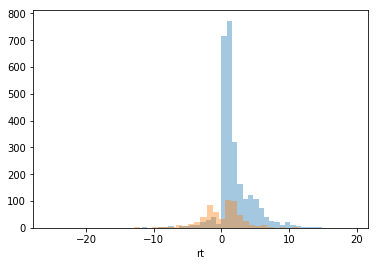

In [413]:
sns.distplot(df1.rt, kde=False, label = "1")
sns.distplot(df2.rt, kde=False, label = "2")

In [32]:
# Split fix experiment players
subjects_fix = list(fix.player.unique())
sample_subj = random.sample(subjects_fix, int(np.round(len(subjects_fix) * 0.7)))

In [33]:
train_fix = fix.loc[fix.player.isin(sample_subj)]
test_fix = fix.loc[~fix.player.isin(sample_subj)]
train_fix.shape

(4100, 16)

In [20]:
actions_list = ['DC', 'CD', 'DD', 'CC']
svo = ["Pro-social", "Pro-self"]
modeler = ddm.HDDMmodelMaker()
st = time.time()
for a in actions_list:
    for s in svo:
        df = train_fix.loc[(train_fix["prev"]==a) & (train_fix["type"]==s)]
        try:
            model = modeler.fit_model(df, 5000, 200)
            print("\nModel: %s, time: %f\n" % (a, time.time() - st))
            model.get_traces().to_csv("./outputs/%s_%s_svo.csv" % (a, s))
        except: break

 [-----------------100%-----------------] 5000 of 5000 complete in 8.2 sec
Model: DC, time: 8.275946

 [-----------------100%-----------------] 5000 of 5000 complete in 9.0 sec
Model: DC, time: 17.443475

 [-----------------100%-----------------] 5000 of 5000 complete in 9.3 sec
Model: CD, time: 26.823665

 [-----------------100%-----------------] 5000 of 5000 complete in 7.5 sec
Model: CD, time: 34.416995

 [-----------------100%-----------------] 5000 of 5000 complete in 7.9 sec
Model: DD, time: 42.416457

 [-----------------100%-----------------] 5000 of 5000 complete in 21.0 sec
Model: DD, time: 63.541271

 [-----------------100%-----------------] 5000 of 5000 complete in 30.6 sec
Model: CC, time: 94.285924

 [-----------------100%-----------------] 5000 of 5000 complete in 6.6 sec
Model: CC, time: 100.944349



In [16]:
def print_traces (svo, param, context = ""):
    if context == "":
        df = pd.read_csv("./outputs/%s_svo.csv" % (svo))
    else: df = pd.read_csv("./outputs/%s_%s_svo.csv" % (context, svo))
    
    return df[param]

In [ ]:
actions_list = ['DC', 'CD', 'DD', 'CC']
for u in test_fix.player.unique():
    for a in actions_list:
        df = test_fix.loc[(test_fix["prev"]==a) & (test_fix["player"]==u)]
        print("\nModel: %s, Rows: %d, time: %f\n" % (a, len(df.index), time.time() - st))
        try:
            model = modeler.fit_model(df, 5000, 200)
            
            model.gen_stats().to_csv("./outputs/%s_%s.csv" % (a, u))
        except: break


Model: DC, Rows: 1, time: 69189.415165

 [-----------------100%-----------------] 5000 of 5000 complete in 10.3 secPlotting a
Plotting v
Plotting t
Plotting z

Model: CD, Rows: 2, time: 69200.193809

 [-----------------53%                  ] 2657 of 5000 complete in 6.0 secHalting at iteration  2818  of  5000
Plotting a
Plotting v
Plotting t
Plotting z

Model: DD, Rows: 1, time: 69207.017659

Halting at iteration  117  of  5000
Could not generate output statistics for a
Could not generate output statistics for z_trans
Could not generate output statistics for t
Could not generate output statistics for z
Could not generate output statistics for v

Model: DC, Rows: 0, time: 69207.370695


Model: DC, Rows: 2, time: 69207.373491

Halting at iteration  61  of  5000
Could not generate output statistics for z_trans
Could not generate output statistics for z
Could not generate output statistics for a
Could not generate output statistics for v
Could not generate output statistics for t

Model: 

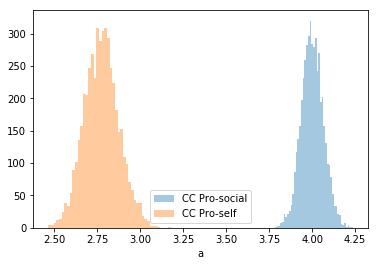

In [19]:
sns.distplot(print_traces("Pro-social", "a","CC" ), kde=False, label = "CC Pro-social")
sns.distplot(print_traces( "Pro-self", "a","CC"), kde=False, label = "CC Pro-self")
plt.legend()




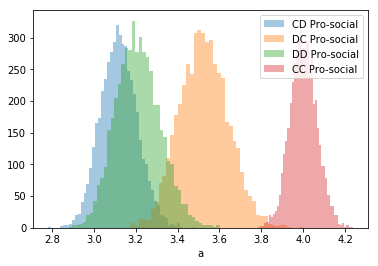

In [20]:
sns.distplot(print_traces("Pro-social", "a", "CD"), kde=False, label = "CD Pro-social")
sns.distplot(print_traces("Pro-social", "a", "DC"), kde=False, label = "DC Pro-social")
sns.distplot(print_traces("Pro-social", "a", "DD"), kde=False, label = "DD Pro-social")
sns.distplot(print_traces("Pro-social", "a", "CC"), kde=False, label = "CC Pro-social")
plt.legend()

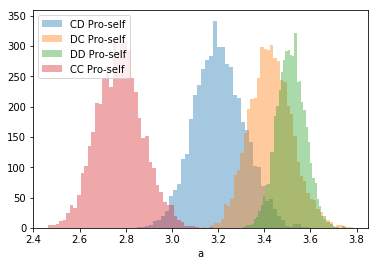

In [21]:
sns.distplot(print_traces("Pro-self", "a", "CD"), kde=False, label = "CD Pro-self")
sns.distplot(print_traces("Pro-self", "a", "DC"), kde=False, label = "DC Pro-self")
sns.distplot(print_traces("Pro-self", "a", "DD"), kde=False, label = "DD Pro-self")
sns.distplot(print_traces("Pro-self", "a", "CC"), kde=False, label = "CC Pro-self")
plt.legend()

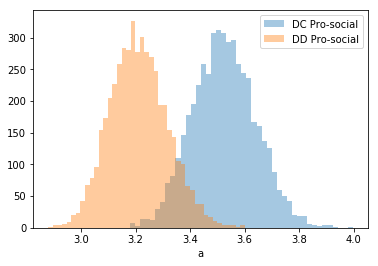

In [22]:
sns.distplot(print_traces("Pro-social", "a", "DC"), kde=False, label = "DC Pro-social")
sns.distplot(print_traces("Pro-social", "a", "DD"), kde=False, label = "DD Pro-social")
plt.legend()

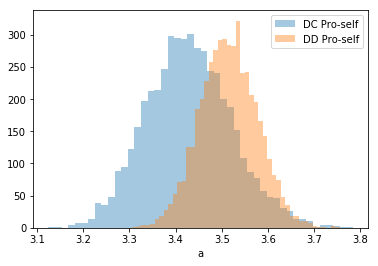

In [23]:
sns.distplot(print_traces("Pro-self", "a", "DC"), kde=False, label = "DC Pro-self")
sns.distplot(print_traces("Pro-self", "a", "DD"), kde=False, label = "DD Pro-self")

plt.legend()

In [255]:
test_fix.loc[test_fix.player == player]

,Unnamed: 0,round,player,action_player,opponent,action_opponent,payoff,rt,session,treatment,actions,response,abs_time,prev,type,user
11500,10213,1,s9n3_usuario1,C,['s9n3_usuario18'],C,3,15.044,s9n3,fix,00C,1,15.044,00,Pro-self,s9n3_usuario1
11501,10231,2,s9n3_usuario1,C,['s9n3_usuario18'],D,0,12.809,s9n3,fix,CCC,1,12.809,CC,Pro-self,s9n3_usuario1
11502,10249,3,s9n3_usuario1,D,['s9n3_usuario18'],D,1,-9.759,s9n3,fix,CDD,0,9.759,CD,Pro-self,s9n3_usuario1
11503,10267,4,s9n3_usuario1,D,['s9n3_usuario18'],C,4,-4.719,s9n3,fix,DDD,0,4.719,DD,Pro-self,s9n3_usuario1
11504,10285,5,s9n3_usuario1,C,['s9n3_usuario18'],D,0,5.157,s9n3,fix,DCC,1,5.157,DC,Pro-self,s9n3_usuario1
11505,10303,6,s9n3_usuario1,D,['s9n3_usuario18'],D,1,-4.125,s9n3,fix,CDD,0,4.125,CD,Pro-self,s9n3_usuario1
11506,10321,7,s9n3_usuario1,C,['s9n3_usuario18'],D,0,4.554,s9n3,fix,DDC,1,4.554,DD,Pro-self,s9n3_usuario1
11507,10339,8,s9n3_usuario1,D,['s9n3_usuario18'],C,4,-2.890,s9n3,fix,CDD,0,2.890,CD,Pro-self,s9n3_usuario1
11508,10357,9,s9n3_usuario1,D,['s9n3_usuario18'],C,4,-4.521,s9n3,fix,DCD,0,4.521,DC,Pro-self,s9n3_usuario1
11509,10375,10,s9n3_usuario1,D,['s9n3_usuario18'],D,1,-5.544,s9n3,fix,DCD,0,5.544,DC,Pro-self,s9n3_usuario1


In [34]:

player = random.choice(test_fix.player.unique())

In [35]:
prev = "CD"
df = test_fix.loc[(test_fix.prev == prev) & (test_fix.player == player)]
print("%s %s %d" % (prev, player, len(df.index)))
models = list()
for i in range(5):
    model = modeler.fit_model(df, 5000, 200)
    models.append(model)
    
hddm.analyze.gelman_rubin(models)

CD s4m8_usuario10 1
 [-----------------100%-----------------] 5000 of 5000 complete in 10.1 sec

{'a': 0.9999815253587857,
 't': 1.0000222692380967,
 'v': 0.999983749967013,
 'z_trans': 0.999948646541305}

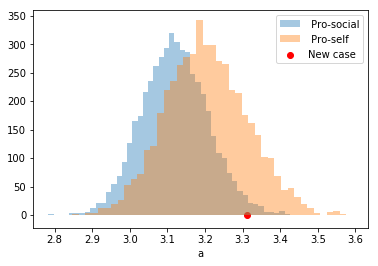

In [258]:
param = "a"
sns.distplot(print_traces("Pro-social", param, prev), kde=False, label = " Pro-social")
sns.distplot(print_traces("Pro-self", param, prev), kde=False, label = " Pro-self")
plt.scatter(x=np.mean(model.get_traces()[param]), y=0, color='r', label = 'New case')
plt.legend()

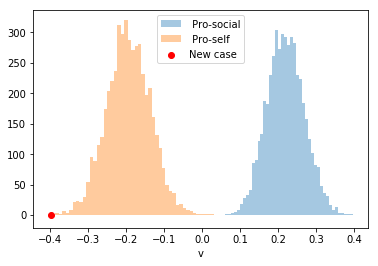

In [259]:
param = "v"
sns.distplot(print_traces("Pro-social", param, prev), kde=False, label = " Pro-social")
sns.distplot(print_traces("Pro-self", param, prev), kde=False, label = " Pro-self")
plt.scatter(x=np.mean(model.get_traces()[param]), y=0, color='r', label = 'New case')
plt.legend()

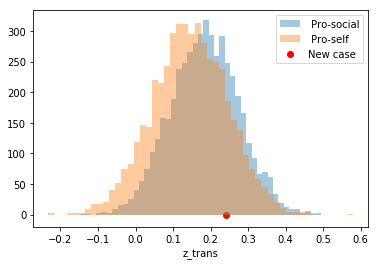

In [260]:
param = "z_trans"
sns.distplot(print_traces("Pro-social", param, prev), kde=False, label = " Pro-social")
sns.distplot(print_traces("Pro-self", param, prev), kde=False, label = " Pro-self")
plt.scatter(x=np.mean(model.get_traces()[param]), y=0, color='r', label = 'New case')
plt.legend()

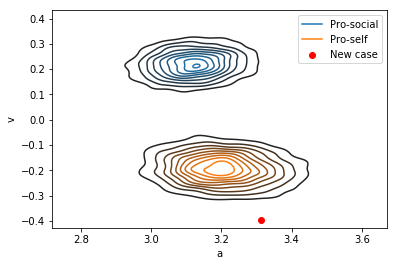

In [261]:
sns.kdeplot(print_traces("Pro-social", "a", prev), print_traces("Pro-social", "v", prev), label = "Pro-social")
sns.kdeplot(print_traces("Pro-self", "a", prev), print_traces("Pro-self", "v", prev),  label = "Pro-self")
plt.scatter(x=np.mean(model.get_traces()["a"]), y=np.mean(model.get_traces()["v"]), color='r', label = 'New case')
plt.legend()

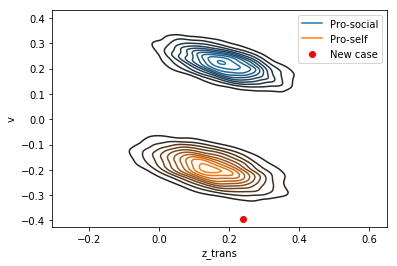

In [262]:
sns.kdeplot(print_traces("Pro-social", "z_trans", prev), print_traces("Pro-social", "v", prev), label = "Pro-social")
sns.kdeplot(print_traces("Pro-self", "z_trans", prev), print_traces("Pro-self", "v", prev),  label = "Pro-self")
plt.scatter(x=np.mean(model.get_traces()["z_trans"]), y=np.mean(model.get_traces()["v"]), color='r', label = 'New case')
plt.legend()

In [135]:
#actions_list = ['DC', 'CD', 'DD', 'CC']
svo = ["Pro-social", "Pro-self"]
modeler = ddm.HDDMmodelMaker()
st = time.time()
for s in svo:
    df = train_fix.loc[train_fix["type"]==s]
    try:
        model = modeler.fit_model(df, 5000, 200)
        print("\nModel: %s, time: %f\n" % (s, time.time() - st))
        model.get_traces().to_csv("./outputs/%s_svo.csv" % (s))
    except: break

 [-----------------100%-----------------] 5000 of 5000 complete in 44.8 sec
Model: Pro-social, time: 44.886378

 [-----------------100%-----------------] 5000 of 5000 complete in 34.1 sec
Model: Pro-self, time: 79.119815



In [96]:
player = random.choice(test_fix.player.unique())
df = test_fix.loc[(test_fix["round"] <= 10) & (test_fix.player == player)]
print("%s %s %d" % (prev, player, len(df.index)))
models = list()
for i in range(5):
    model = modeler.fit_model(df, 5000, 200)
    models.append(model)
hddm.analyze.gelman_rubin(models)
#combined_model = kabuki.utils.concat_models(models)


CD s9n3_usuario7 10
 [-----------------100%-----------------] 5000 of 5000 complete in 10.7 sec

{'a': 0.999926637766305,
 't': 1.0000469409078043,
 'v': 1.0000603940201467,
 'z_trans': 1.0003156663749417}

In [97]:
#df = test_fix.loc[(test_fix["round"] <= 20) & (test_fix.player == player)]
#print("%s %s %d" % (prev, player, len(df.index)))
#models = list()
#for i in range(5):
#    model2 = modeler.fit_model(df, 5000, 200)
#    models.append(model2)
#hddm.analyze.gelman_rubin(models)

In [98]:
#df = test_fix.loc[(test_fix["round"] <= 70) & (test_fix.player == player)]
#print("%s %s %d" % (prev, player, len(df.index)))
#model7 = modeler.fit_model(df, 5000, 200)


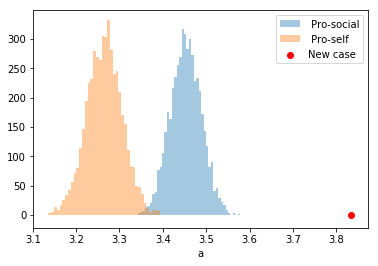

In [99]:
param = "a"
sns.distplot(print_traces("Pro-social", param), kde=False, label = " Pro-social")
sns.distplot(print_traces("Pro-self", param), kde=False, label = " Pro-self")
#plt.scatter(x=np.mean(model2.get_traces()[param]), y=0, color='g', label = 'New case 20 rounds')
#plt.scatter(x=np.mean(model7.get_traces()[param]), y=0, color='b', label = 'New case 70 rounds')
plt.scatter(x=np.mean(model.get_traces()[param]), y=0, color='r', label = 'New case')
plt.legend()

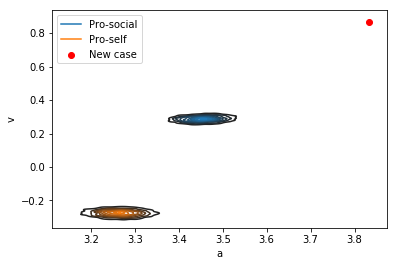

In [100]:
sns.kdeplot(print_traces("Pro-social", "a"), print_traces("Pro-social", "v"), label = "Pro-social")
sns.kdeplot(print_traces("Pro-self", "a"), print_traces("Pro-self", "v"),  label = "Pro-self")
plt.scatter(x=np.mean(model.get_traces()["a"]), y=np.mean(model.get_traces()["v"]), color='r', label = 'New case')
#plt.scatter(x=np.mean(model2.get_traces()["a"]), y=np.mean(model2.get_traces()["v"]), color='b', label = 'New case 20 rounds')
#plt.scatter(x=np.mean(model7.get_traces()["a"]), y=np.mean(model7.get_traces()["v"]), color='g', label = 'New case 70 rounds')
plt.legend()

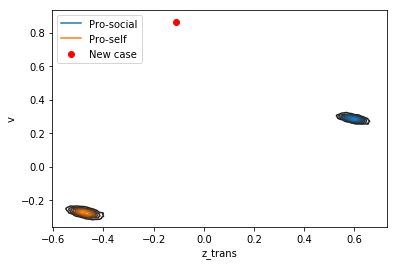

In [101]:
sns.kdeplot(print_traces("Pro-social", "z_trans"), print_traces("Pro-social", "v"), label = "Pro-social")
sns.kdeplot(print_traces("Pro-self", "z_trans"), print_traces("Pro-self", "v"),  label = "Pro-self")
plt.scatter(x=np.mean(model.get_traces()["z_trans"]), y=np.mean(model.get_traces()["v"]), color='r', label = 'New case')
#plt.scatter(x=np.mean(model2.get_traces()["z_trans"]), y=np.mean(model2.get_traces()["v"]), color='b', label = 'New case 20 rounds')
#plt.scatter(x=np.mean(model7.get_traces()["z_trans"]), y=np.mean(model7.get_traces()["v"]), color='g', label = 'New case 70 rounds')
plt.legend(loc = "upper left")

In [102]:
fix.loc[fix.player == player]

,Unnamed: 0,round,player,action_player,opponent,action_opponent,payoff,rt,session,treatment,actions,response,abs_time,prev,type,user
10600,10204,1,s9n3_usuario7,C,['s9n3_usuario4'],C,3,7.192,s9n3,fix,00C,1,7.192,00,Pro-social,s9n3_usuario7
10601,10222,2,s9n3_usuario7,C,['s9n3_usuario4'],C,3,5.506,s9n3,fix,CCC,1,5.506,CC,Pro-social,s9n3_usuario7
10602,10240,3,s9n3_usuario7,C,['s9n3_usuario4'],C,3,2.689,s9n3,fix,CCC,1,2.689,CC,Pro-social,s9n3_usuario7
10603,10258,4,s9n3_usuario7,C,['s9n3_usuario4'],C,3,2.639,s9n3,fix,CCC,1,2.639,CC,Pro-social,s9n3_usuario7
10604,10276,5,s9n3_usuario7,C,['s9n3_usuario4'],C,3,1.848,s9n3,fix,CCC,1,1.848,CC,Pro-social,s9n3_usuario7
10605,10294,6,s9n3_usuario7,C,['s9n3_usuario4'],C,3,1.854,s9n3,fix,CCC,1,1.854,CC,Pro-social,s9n3_usuario7
10606,10312,7,s9n3_usuario7,C,['s9n3_usuario4'],C,3,1.914,s9n3,fix,CCC,1,1.914,CC,Pro-social,s9n3_usuario7
10607,10330,8,s9n3_usuario7,C,['s9n3_usuario4'],C,3,2.064,s9n3,fix,CCC,1,2.064,CC,Pro-social,s9n3_usuario7
10608,10348,9,s9n3_usuario7,C,['s9n3_usuario4'],C,3,2.169,s9n3,fix,CCC,1,2.169,CC,Pro-social,s9n3_usuario7
10609,10366,10,s9n3_usuario7,C,['s9n3_usuario4'],C,3,1.473,s9n3,fix,CCC,1,1.473,CC,Pro-social,s9n3_usuario7


In [24]:
actions.loc[actions.treatment == "fix"]

,00C,00D,CCC,CCD,CDC,CDD,DCC,DCD,DDC,DDD,type,user,treatment
18,0.0,1.0,95.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,Pro-social,s4m8_usuario2,fix
19,1.0,0.0,95.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,Pro-social,s4m8_usuario7,fix
20,1.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pro-social,s4m8_usuario14,fix
21,1.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pro-social,s4m8_usuario13,fix
22,0.0,1.0,96.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,Pro-social,s4m8_usuario9,fix
23,1.0,0.0,96.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,Pro-social,s4m8_usuario10,fix
24,1.0,0.0,40.0,13.0,20.0,2.0,8.0,5.0,7.0,4.0,Pro-social,s4m8_usuario8,fix
25,1.0,0.0,53.0,0.0,1.0,12.0,11.0,11.0,1.0,10.0,Pro-social,s4m8_usuario1,fix
26,0.0,1.0,56.0,5.0,9.0,3.0,3.0,5.0,6.0,12.0,Pro-social,s4m8_usuario11,fix
27,0.0,1.0,60.0,1.0,2.0,6.0,6.0,6.0,2.0,16.0,Pro-social,s4m8_usuario4,fix


In [25]:
fix.loc[fix.player == "s9n3_usuario14"].response.value_counts()

1    68
0    32
Name: response, dtype: int64

In [41]:
f = actions.loc[actions.treatment == "fix"]
f["type"].value_counts()

Pro-social    34
Pro-self      24
Name: type, dtype: int64

In [26]:
model = hddm.HDDM(fix.loc[fix.player == "s9n3_usuario14"], bias = True)
model.sample(10000, burn = 100)
model.gen_stats()

 [-----------------100%-----------------] 10000 of 10000 complete in 14.5 sec

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,3.36489,0.164134,3.06452,3.25151,3.35801,3.47,3.69988,0.00246636
v,0.0645185,0.0759883,-0.0841304,0.0126683,0.0633479,0.115672,0.217272,0.00110861
t,0.784687,0.0777907,0.612829,0.737154,0.793194,0.84061,0.91382,0.00133858
z,0.63138,0.0350151,0.560124,0.608075,0.632216,0.655395,0.696984,0.000559279


In [29]:
modeler = ddm.HDDMmodelMaker()
modeler.

AttributeError: HDDMmodelMaker instance has no attribute 'gen_synthetic_data'

In [362]:
fix.loc[fix.player == "s4m8_usuario14"]

,Unnamed: 0,round,player,action_player,opponent,action_opponent,payoff,rt,session,treatment,actions,response,abs_time,prev,type,user
2000,1802,1,s4m8_usuario14,C,['s4m8_usuario13'],C,3,5.394,s4m8,fix,00C,1,5.394,00,Pro-social,s4m8_usuario14
2001,1816,2,s4m8_usuario14,C,['s4m8_usuario13'],C,3,5.883,s4m8,fix,CCC,1,5.883,CC,Pro-social,s4m8_usuario14
2002,1830,3,s4m8_usuario14,C,['s4m8_usuario13'],C,3,5.554,s4m8,fix,CCC,1,5.554,CC,Pro-social,s4m8_usuario14
2003,1844,4,s4m8_usuario14,C,['s4m8_usuario13'],C,3,7.202,s4m8,fix,CCC,1,7.202,CC,Pro-social,s4m8_usuario14
2004,1858,5,s4m8_usuario14,C,['s4m8_usuario13'],C,3,6.484,s4m8,fix,CCC,1,6.484,CC,Pro-social,s4m8_usuario14
2005,1872,6,s4m8_usuario14,C,['s4m8_usuario13'],C,3,10.686,s4m8,fix,CCC,1,10.686,CC,Pro-social,s4m8_usuario14
2006,1886,7,s4m8_usuario14,C,['s4m8_usuario13'],C,3,10.366,s4m8,fix,CCC,1,10.366,CC,Pro-social,s4m8_usuario14
2007,1900,8,s4m8_usuario14,C,['s4m8_usuario13'],C,3,10.293,s4m8,fix,CCC,1,10.293,CC,Pro-social,s4m8_usuario14
2008,1914,9,s4m8_usuario14,C,['s4m8_usuario13'],C,3,12.879,s4m8,fix,CCC,1,12.879,CC,Pro-social,s4m8_usuario14
2009,1928,10,s4m8_usuario14,C,['s4m8_usuario13'],C,3,11.457,s4m8,fix,CCC,1,11.457,CC,Pro-social,s4m8_usuario14


In [42]:
#actions_list = ['DC', 'CD', 'DD', 'CC']
svo = ["Pro-social", "Pro-self"]
modeler = ddm.HDDMmodelMaker()
st = time.time()
#for s in svo:
df_soc = train_fix.loc[train_fix["type"]=="Pro-social"]
df_sel = train_fix.loc[train_fix["type"]=="Pro-self"]
df_sel["subj_idx"] = df_sel["player"]
df_soc["subj_idx"] = df_soc["player"]
model_soc = modeler.fit_model(df_soc, 5000, 200)
model_sel = modeler.fit_model(df_sel, 5000, 200)



/Users/eladiomontero/opt/anaconda3/envs/decTimesEnv/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/eladiomontero/opt/anaconda3/envs/decTimesEnv/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


 [-----------------100%-----------------] 5000 of 5000 complete in 140.1 sec

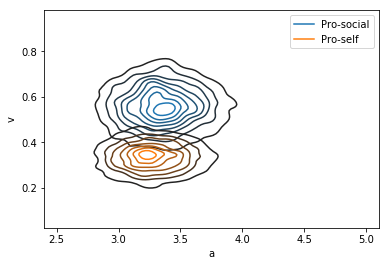

In [48]:
sns.kdeplot(model_soc.get_traces()["a"], np.abs(model_soc.get_traces()["v"]), label = "Pro-social")
sns.kdeplot(model_sel.get_traces()["a"], np.abs(model_sel.get_traces()["v"]),  label = "Pro-self")
plt.legend()

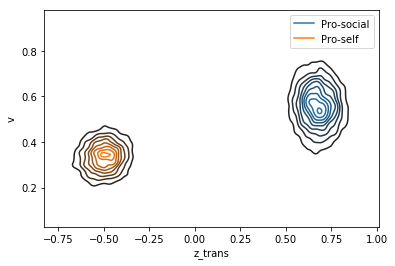

In [49]:
sns.kdeplot(model_soc.get_traces()["z_trans"], np.abs(model_soc.get_traces()["v"]), label = "Pro-social")
sns.kdeplot(model_sel.get_traces()["z_trans"], np.abs(model_sel.get_traces()["v"]),  label = "Pro-self")
plt.legend()

In [73]:
mean_soc = modeler.get_stats(model_soc, subjects = True)
mean_sel = modeler.get_stats(model_sel, subjects = True)

mean_soc = mean_soc.dropna()
mean_sel = mean_sel.dropna()

a_soc = mean_soc.loc[mean_soc["param"] == "a", ["mean"]]
a_sel = mean_sel.loc[mean_sel["param"] == "a", ["mean"]]
v_soc = mean_soc.loc[mean_soc["param"] == "v", ["mean"]]
v_sel = mean_sel.loc[mean_sel["param"] == "v", ["mean"]]
z_soc = mean_soc.loc[mean_soc["param"] == "z", ["mean"]]
z_sel = mean_sel.loc[mean_sel["param"] == "z", ["mean"]]

In [89]:
soc = {"a": [a_soc], "v": [v_soc], "z" : [z_soc], "y": "soc"}
soc_df = pd.DataFrame(soc, columns = ["a", "v", "z", "y"])
#sel_params = {"a": a_sel, "v": v_sel, "z" : z_sel, "y": "self"}

soc_df

,a,v,z,y
0,mean 2 3.76823 3 2.70489 4 5.2389...,mean 27 0.699078 28 0.132892 29 ...,mean 77 0.653247 78 0.594947 79 0.6...,soc


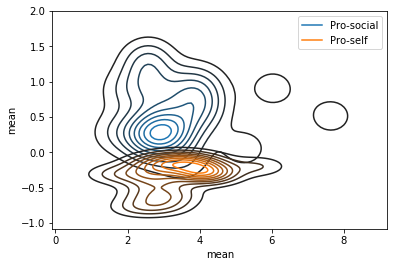

In [72]:
sns.kdeplot(a_soc["mean"], v_soc["mean"], label = "Pro-social")
sns.kdeplot(a_sel["mean"], v_sel["mean"],  label = "Pro-self")

plt.legend()

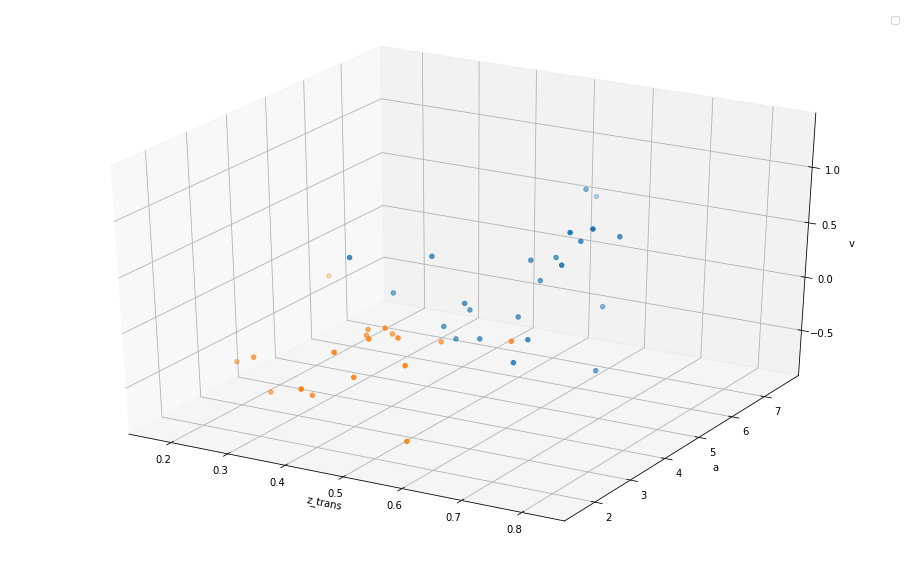

In [76]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=z_soc, 
    ys=a_soc, 
    zs=v_soc
)
ax.scatter(
    xs=z_sel, 
    ys=a_sel, 
    zs=v_sel
)
#ax.scatter(
#    xs=np.mean(model.get_traces()["z_trans"]),
#    ys=np.mean(model.get_traces()["a"]),
#    zs=np.mean(model.get_traces()["a"]), 
#    color='r', label = 'New case'
#)
ax.set_xlabel('z_trans')
ax.set_ylabel('a')
ax.set_zlabel('v')
plt.legend()
plt.show()

In [79]:
from sklearn.manifold import TSNE

Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [ ]:
test_tsne = TSNE(random_state=RS).fit_transform(x_subset)

In [163]:
#Changing partners
chang = data_svo[data_svo.treatment == "changing"]
for a in chang.prev.unique():
    for t in chang["type"].unique():
        df = chang.loc[(chang.prev == a) & (chang["type"] == t)]
        print("%s %s %d" % (a, t, len(df.index)))
        

00 Pro-self 75
00 Pro-social 21
DD Pro-self 4357
DD Pro-social 521
CC Pro-self 393
CC Pro-social 413
CD Pro-self 945
CD Pro-social 965
DC Pro-self 1730
DC Pro-social 180


In [164]:
chang["type"].value_counts()

Pro-self      7500
Pro-social    2100
Name: type, dtype: int64

In [166]:
# Split fix experiment players
subjects_chang = list(chang.player.unique())
sample_subj_ch = random.sample(subjects_chang, int(np.round(len(subjects_chang) * 0.7)))

In [168]:
train_ch = chang.loc[chang.player.isin(sample_subj_ch)]
test_ch = chang.loc[~chang.player.isin(sample_subj_ch)]
train_ch.shape

(6700, 16)

In [169]:
actions_list = ['DC', 'CD', 'DD', 'CC']
svo = ["Pro-social", "Pro-self"]
modeler = ddm.HDDMmodelMaker()
st = time.time()
for a in actions_list:
    for s in svo:
        df = train_ch.loc[(train_ch["prev"]==a) & (train_ch["type"]==s)]
        try:
            model = modeler.fit_model(df, 5000, 200)
            print("\nModel: %s, time: %f\n" % (a, time.time() - st))
            model.get_traces().to_csv("./outputs/%s_%s_svo.csv" % (a, s))
        except: break

 [-----------------100%-----------------] 5000 of 5000 complete in 7.7 sec
Model: DC, time: 7.864616

 [-----------------100%-----------------] 5000 of 5000 complete in 25.3 sec
Model: DC, time: 33.283826

 [-----------------100%-----------------] 5000 of 5000 complete in 15.1 sec
Model: CD, time: 48.536270

 [-----------------100%-----------------] 5000 of 5000 complete in 15.4 sec
Model: CD, time: 64.052168

 [-----------------100%-----------------] 5000 of 5000 complete in 11.2 sec
Model: DD, time: 75.368049

 [-----------------100%-----------------] 5000 of 5000 complete in 54.9 sec
Model: DD, time: 130.441379

 [-----------------100%-----------------] 5000 of 5000 complete in 8.5 sec
Model: CC, time: 139.074229

 [-----------------100%-----------------] 5000 of 5000 complete in 9.7 sec
Model: CC, time: 148.889953

